In [1]:
import numpy as np
import matplotlib.pyplot as plt

import blacksky
import histlite as hl

In [2]:
from nsb.atmosphere import scattering, extinction
from nsb.emitter import moon, airglow, galactic, zodiacal, stars

from nsb import ASSETS_PATH
from nsb.instrument import BANDPASS_PATH
from nsb.core import Frame, Model
from nsb.core.instrument import Instrument, Camera, Bandpass

# Running the pipeline for pSCT

## Building the camera:
For cameras without raytraced response histograms, an analytical function can be used for 'pseudo-raytracing', as long as the camera geometry is implemented in ctapipe:

In [3]:
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
cam = CameraGeometry.from_name('SCTCam')

/home/anonymous/.local/lib/python3.10/site-packages/ctapipe/instrument/camera/geometry.py:616: FromNameWarning: .from_name uses pre-defined data that is likely different from the data being analyzed. Access instrument information via the SubarrayDescription instead.
  warn_from_name()


The psf needs to be a function of the off-axis angle, position angle and separation rho (all in radian). An approximate solution is to have a term that adds the standard deviation quadratically for an off-axis component and a base standard deviation. Here we tune the values to replicate the 80% containment radius of about 2.5 arcmin from arxiv:2010.13027.

In [25]:
%%time
c_bins = [np.linspace(0, np.deg2rad(5), 50), np.linspace(0, 2*np.pi, 20), np.linspace(0, 2*1e-3, 100)]

def psf(off, pos, rho):
    p = [0.41, 0.1]
    off = off/np.deg2rad(4)
    
    sigma = np.sqrt(p[0]**2 + p[1]*off**2)*1e-3
    
    return np.sin(rho)/(2*np.pi*sigma**2) * np.exp(-rho**2/(2*sigma**2))

h_psf = hl.hist_from_eval(psf, bins=c_bins)
cam = CameraGeometry.from_name('SCTCam')

sct_mirror_area = 50*0.88
sct_focal_length = 5.59

pSCT_cam = Camera.from_ctapipe(cam, h_psf, sct_mirror_area, sct_focal_length, d_grid=32)

/home/anonymous/.local/lib/python3.10/site-packages/ctapipe/instrument/camera/geometry.py:616: FromNameWarning: .from_name uses pre-defined data that is likely different from the data being analyzed. Access instrument information via the SubarrayDescription instead.
  warn_from_name()


CPU times: user 18min 27s, sys: 731 ms, total: 18min 28s
Wall time: 18min 32s


As a bandpass we use the HESS bandpass. This likely underestimates the bandpass, since HESS1U is quite inefficent.

In [26]:
ct1_bandpass = Bandpass.from_csv(BANDPASS_PATH+'hess1u_ct1.dat')

## Creating the model:

In [27]:
# Sources:
glow = airglow.Noll2012({"H": 87})
zodi = zodiacal.Masana2021({})
jons = moon.Jones2013({})
scat = stars.GaiaDR3({'catalog_file':ASSETS_PATH+'gaiadr3.npy', 'magmin':-3, 'magmax':20})
smap = stars.GaiaDR3Mag15({'magnitude_maps':ASSETS_PATH+'gaia_mag15plus.npy'})

# Atmospheric Extinction:
atm_airglow = extinction.Noll2012({'scale':1.6, 'offset':-0.16})([glow])
atm_diffuse = extinction.Masana2021({'gamma':0.5})([zodi])
atm_stellar = extinction.Masana2021({'gamma':1})([scat, smap])

# Atmospheric Scattering:
conf_mie = {"parameters": [0.8],
            "bins": [np.linspace(0, np.pi, 1000)]}      
conf_ray = {"parameters": [0.0148],
            "bins": [np.linspace(0, np.pi, 1000)]}
atm_ray = scattering.Rayleigh(conf_ray)([jons]).map(np.deg2rad(180))
atm_mie = scattering.Mie(conf_mie)([jons]).map(np.deg2rad(180))

# Camera:
pSCT = Instrument({'camera':pSCT_cam, 'bandpass':ct1_bandpass}, 1)([atm_ray, atm_mie, atm_airglow, atm_diffuse, atm_stellar])

In [28]:
%%time
model = Model(pSCT)
model.compile()

/home/anonymous/.local/lib/python3.10/site-packages/blacksky/photometric.py:32: RuntimeWarning: invalid value encountered in subtract
  color = magnitudes[j[0]] - magnitudes[j[1]]


CPU times: user 51 s, sys: 3.5 s, total: 54.5 s
Wall time: 54.7 s


## Predicting for IACTs:
To predict a rate, we need to pass a frame to our model. This depends on location, observation time, target, fov, rotation of the telescope around its axis and the wavelength binning.

Atmospheric conditions can also be influenced, with:
- The aerosol single scattering albedo
- The aeronet 380nm coefficients
- The expected solar flux level in sfu 10.7, ideally 4.5 days in advance of the measurement

In [141]:
import astropy
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u

In [173]:
location = EarthLocation.of_site('Whipple Observatory')
obstime  = astropy.time.Time('2021-11-11T21:14:16', format='isot', scale='utc')
target   = SkyCoord.from_name('sgr a*')

frame = Frame(location, obstime, target, 7, 0*u.deg, np.linspace(270, 730, 100)*u.nm, albedo=0.95, aero=[0.065, 1.2], sfu=75)

In [175]:
%%time
res = model.predict(frame)

CPU times: user 6.33 s, sys: 2.85 s, total: 9.19 s
Wall time: 9.24 s


## Visualizing:
Using ctapipes CameraDisplay, it can be visualized easily:

In [182]:
def ctapipe_disp(cam, instrument, rays, ax, label='a.u.', **kwargs):
    display = CameraDisplay(cam, ax=ax, **kwargs)
    display.image = instrument.camera.pix_assign(rays)
    display.add_colorbar(label=label)
    return display

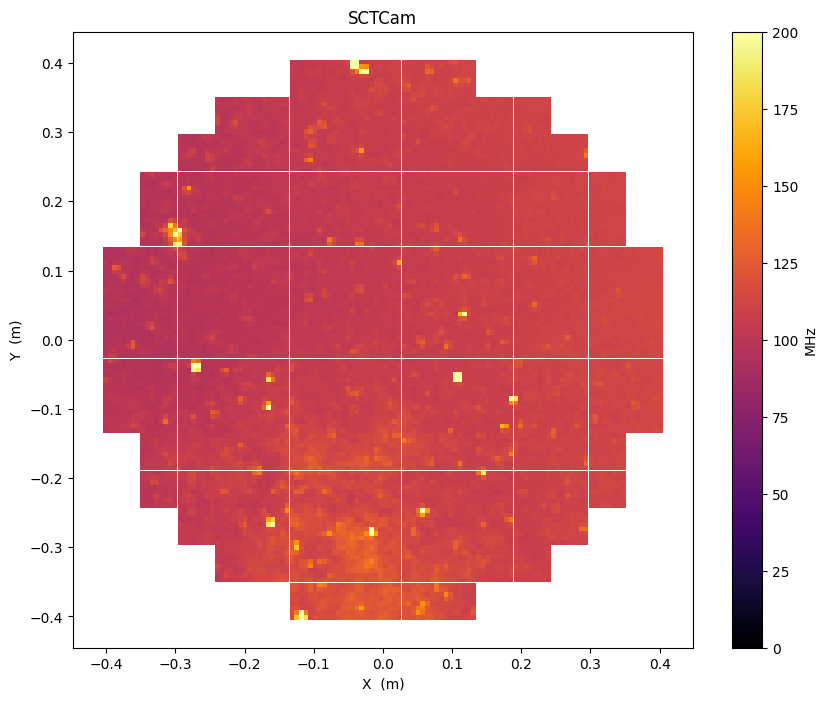

In [186]:
fig, ax = plt.subplots(figsize=(10,8))
disp = ctapipe_disp(cam, pSCT, res*1e-6, ax=ax, label='MHz', show_frame=False)
disp.set_limits_minmax(0, 200)

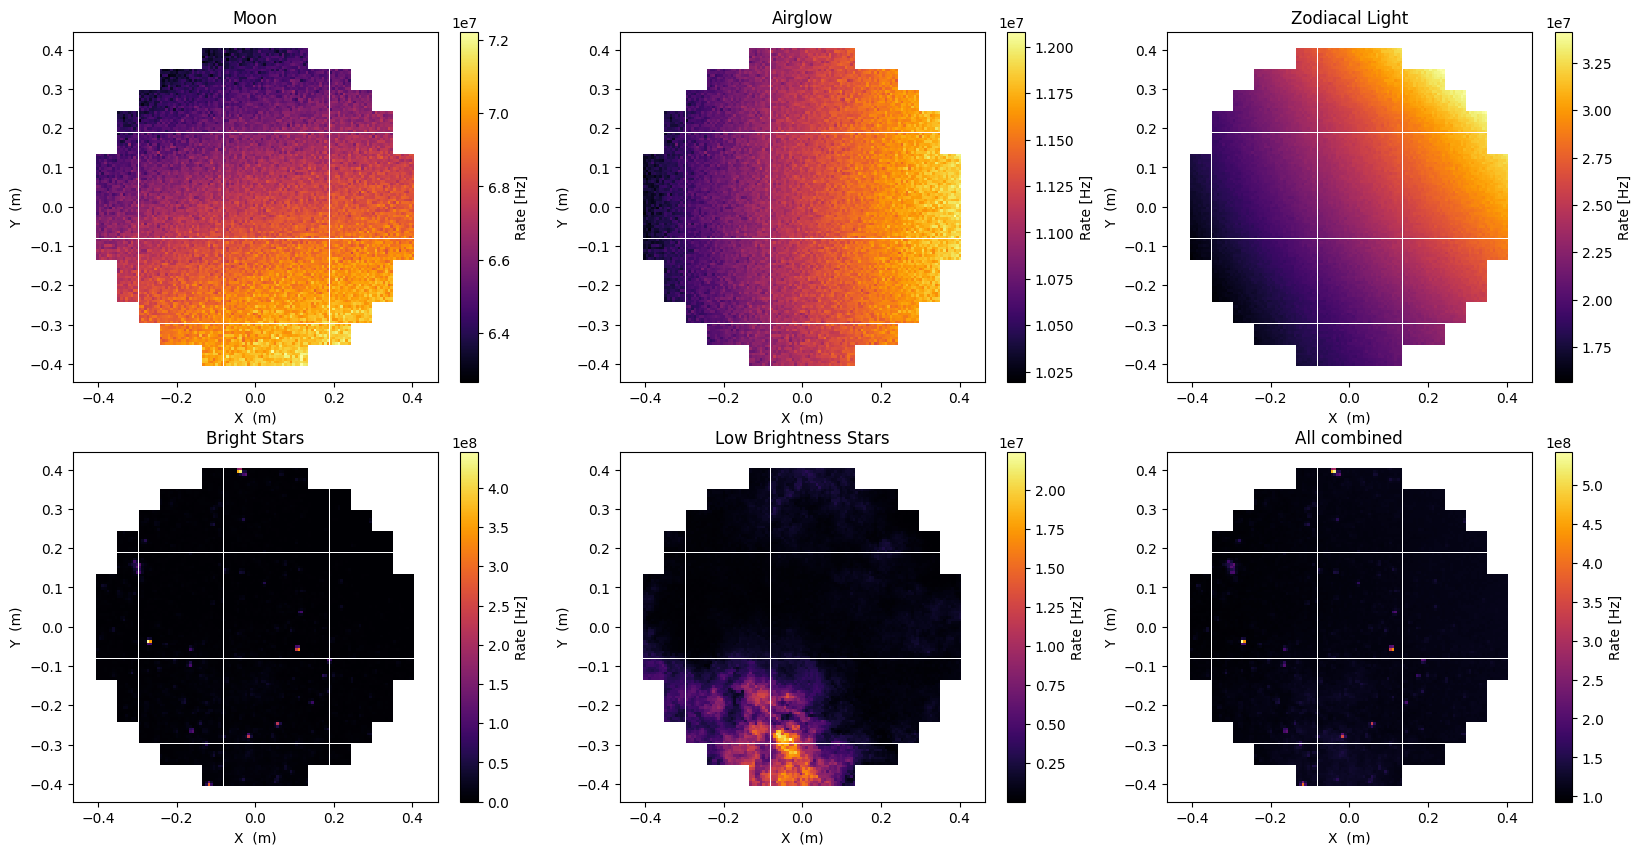

In [187]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
disp1 = ctapipe_disp(cam, pSCT, res[res.source == type(jons)], ax[0,0], 'Rate [Hz]', title='Moon', show_frame=False)
disp2 = ctapipe_disp(cam, pSCT, res[res.source == type(glow)], ax[0,1], 'Rate [Hz]', title='Airglow', show_frame=False)
disp3 = ctapipe_disp(cam, pSCT, res[res.source == type(zodi)], ax[0,2], 'Rate [Hz]', title='Zodiacal Light', show_frame=False)
disp4 = ctapipe_disp(cam, pSCT, res[res.source == type(scat)], ax[1,0], 'Rate [Hz]', title='Bright Stars', show_frame=False)
disp5 = ctapipe_disp(cam, pSCT, res[res.source == type(smap)], ax[1,1], 'Rate [Hz]', title='Low Brightness Stars', show_frame=False)
disp6 = ctapipe_disp(cam, pSCT, res, ax[1,2], 'Rate [Hz]', title='All combined', show_frame=False)